# Assignment 1 - Word2Vec

<b>Name:</b> Nirut Gammayeengoen <b>Student Id:</b> st123472

## Introduction

In this assignment, cbow was implmented and comparison between skipgram and its negative sampling version was made in terms of training time. Also, a window size of 2 was used to get 2 context neigbhors of center word. Samples of text were selected from Wikipedia on 'badminton' and 'python programming language' as a corpus. One preprocessing step was carried out to remove the citations (e.g. [1], [2]) from the corpus since Wikipedia contains many of it.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Skipgrams and Negative Sampling Implementation

## 1) Load Data

https://en.wikipedia.org/wiki/Table_tennis

https://en.wikipedia.org/wiki/C_(programming_language)

In [2]:
import dataset

In [3]:
dataset.table_tennis # try to load table_tennis data

'\nTable tennis, also known as ping-pong and whiff-whaff, is a racket sport derived from tennis but distinguished by its playing surface being atop a stationary table, rather than the court on which players stand. Either individually or in teams of two, players take alternating turns returning a light, hollow ball over the table\'s net onto the opposing half of the court using small rackets until they fail to do so, which results in a point for the opponent. Play is fast, requiring quick reaction and constant attention, and is characterized by an emphasis on spin relative to other ball sports, which can heavily affect the ball\'s trajectory.\n\nOwed to its small minimum playing area, its ability to be played indoors in all climates, and relative accessibility of equipment, table tennis is enjoyed worldwide not just as a competitive sport, but as a common recreational pastime among players of all levels and ages.\n\nTable tennis has been an Olympic sport since 1988,[3] with event catego

In [4]:
dataset.c # try to load c data

'\nC (pronounced /ˈsiː/ – like the letter c)[6] is a general-purpose computer programming language. It was created in the 1970s by Dennis Ritchie, and remains very widely used and influential. By design, C\'s features cleanly reflect the capabilities of the targeted CPUs. It has found lasting use in operating systems, device drivers, protocol stacks, though decreasingly[7] for application software. C is commonly used on computer architectures that range from the largest supercomputers to the smallest microcontrollers and embedded systems.\n\nA successor to the programming language B, C was originally developed at Bell Labs by Ritchie between 1972 and 1973 to construct utilities running on Unix. It was applied to re-implementing the kernel of the Unix operating system.[8] During the 1980s, C gradually gained popularity. It has become one of the most widely used programming languages,[9][10] with C compilers available for practically all modern computer architectures and operating system

## 2) Prepare Data for Training

<b>Steps:</b>
<ol>
    <li>Combine documents</li>
    <li>Remove citation references</li>
    <li>Tokenization</li>
    <li>Remove citation references</li>
    <li>Numericalization</li>
    <li>Creating (context word, outside word) tuples</li>
</ol>

### 2.1) Combine documents

In [5]:
import copy

In [6]:
corpus = copy.copy(dataset.table_tennis)

In [7]:
corpus += dataset.c

In [8]:
assert len(dataset.table_tennis) + len(dataset.c) == len(corpus)

### 2.2) Remove citation references

In [9]:
import re

In [10]:
modified_corpus = re.sub("\[[0-9]+\]", '', corpus)

In [11]:
modified_corpus[:1000]

"\nTable tennis, also known as ping-pong and whiff-whaff, is a racket sport derived from tennis but distinguished by its playing surface being atop a stationary table, rather than the court on which players stand. Either individually or in teams of two, players take alternating turns returning a light, hollow ball over the table's net onto the opposing half of the court using small rackets until they fail to do so, which results in a point for the opponent. Play is fast, requiring quick reaction and constant attention, and is characterized by an emphasis on spin relative to other ball sports, which can heavily affect the ball's trajectory.\n\nOwed to its small minimum playing area, its ability to be played indoors in all climates, and relative accessibility of equipment, table tennis is enjoyed worldwide not just as a competitive sport, but as a common recreational pastime among players of all levels and ages.\n\nTable tennis has been an Olympic sport since 1988, with event categories 

### 2.3) Tokenization

In [12]:
import spacy

In [13]:
nlp = spacy.load("en_core_web_sm")

In [14]:
corpus_tokenized   = []
sentence_tokenized = []

for token in nlp(modified_corpus):
    if token.text == '\n' or token.text == '.':
        if len(sentence_tokenized) > 0:
            corpus_tokenized.append(sentence_tokenized)
            sentence_tokenized = []
        continue
    sentence_tokenized.append(token.text.lower())

In [15]:
print("Tokenize of 4 sample sentences:")
count = 0
for sentence in corpus_tokenized:
    print("Sentence", count + 1)
    print(sentence, end="\n\n") 
    count +=1
    if count == 4:
        break

Tokenize of 4 sample sentences:
Sentence 1
['table', 'tennis', ',', 'also', 'known', 'as', 'ping', '-', 'pong', 'and', 'whiff', '-', 'whaff', ',', 'is', 'a', 'racket', 'sport', 'derived', 'from', 'tennis', 'but', 'distinguished', 'by', 'its', 'playing', 'surface', 'being', 'atop', 'a', 'stationary', 'table', ',', 'rather', 'than', 'the', 'court', 'on', 'which', 'players', 'stand']

Sentence 2
['either', 'individually', 'or', 'in', 'teams', 'of', 'two', ',', 'players', 'take', 'alternating', 'turns', 'returning', 'a', 'light', ',', 'hollow', 'ball', 'over', 'the', 'table', "'s", 'net', 'onto', 'the', 'opposing', 'half', 'of', 'the', 'court', 'using', 'small', 'rackets', 'until', 'they', 'fail', 'to', 'do', 'so', ',', 'which', 'results', 'in', 'a', 'point', 'for', 'the', 'opponent']

Sentence 3
['play', 'is', 'fast', ',', 'requiring', 'quick', 'reaction', 'and', 'constant', 'attention', ',', 'and', 'is', 'characterized', 'by', 'an', 'emphasis', 'on', 'spin', 'relative', 'to', 'other', 'b

### 2.4) Create vocabulary

In [16]:
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))  #vocabs is a term defining all unique words

In [17]:
print("Vocabulary size:", len(vocabs))

Vocabulary size: 674


In [18]:
print(vocabs[:20])

['values', 'was', 'type', 'singles', 'procedures', 'that', 'on', 'resulting', 'structs', 'china', 'from', 'england', 'one', 'area', 'available', 'surface', 'free', 'use', 'various', 'extent']


### 2.5) Numericalization

In [19]:
word2index = {v: idx for idx, v in enumerate(vocabs)}

In [20]:
### Including UNK for words not in vocab
vocabs.append('<UNK>')
word2index['<UNK>'] = len(vocabs) - 1

In [21]:
index2word = {v:k for k, v in word2index.items()}

In [22]:
word2index["which"]

311

In [23]:
index2word[29]

'grouping'

### 2.6) Creating (context word, outside word) tuples

In [24]:
window_size = 2

In [25]:
skipgrams = []

#for each corpus
for sent in corpus_tokenized:
    for i in range(window_size, len(sent) - window_size):
        center_word = word2index[sent[i]]
        outside_words = []
        for j in range(1, window_size + 1):
            outside_words.append(word2index[sent[i-j]])
            outside_words.append(word2index[sent[i+j]])
            
        for o in outside_words:
            skipgrams.append([center_word, o])

skipgrams[:15]

[[341, 278],
 [341, 339],
 [341, 351],
 [341, 527],
 [339, 341],
 [339, 527],
 [339, 278],
 [339, 203],
 [527, 339],
 [527, 203],
 [527, 341],
 [527, 395],
 [203, 527],
 [203, 395],
 [203, 339]]

In [26]:
print("Total samples:", len(skipgrams))

Total samples: 5672


### 2.7) Creating random_batch function

In [27]:
def random_batch(batch_size, corpus, skip_grams):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([skip_grams[i][0]])
        random_labels.append([skip_grams[i][1]])
            
    return np.array(random_inputs), np.array(random_labels)

<b>Test Function</b>

In [28]:
input, label = random_batch(10, corpus_tokenized, skipgrams)

print("Input sample:", input)
print(f"Input shape: {input.shape}", end="\n\n")
print(f"Label sample: {label=}")
print("Label shape:", label.shape)

Input sample: [[ 93]
 [320]
 [210]
 [424]
 [274]
 [229]
 [110]
 [341]
 [564]
 [ 78]]
Input shape: (10, 1)

Label sample: label=array([[341],
       [320],
       [643],
       [594],
       [520],
       [214],
       [528],
       [233],
       [525],
       [505]])
Label shape: (10, 1)


## 3) Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

Defining the probability of sampling negative words

In [29]:
z = 0.001

In [30]:
from collections import Counter

word_count = Counter(flatten(corpus_tokenized))

In [31]:
num_total_words = sum([c for w, c in word_count.items()])
num_total_words

1724

In [32]:
unigram_table = []

for v in vocabs:
    uw = word_count[v]/num_total_words
    uw_alpha = uw ** 0.75
    uw_alpha_dividebyz = int(uw_alpha / z)
    unigram_table.extend([v] * uw_alpha_dividebyz)

## 4) Helper functions for skipgram with negative sampling

In [33]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

In [34]:
import random
def negative_sampling(targets, unigram_table, k):
    batch_size = targets.shape[0]
    neg_samples = []
    #2. for each batch
    for i in range(batch_size):
        #randomly pick k negative words from unigram_table
        target_index = targets[i].item()  #looping each of the batch....
        nsample = []
        while len(nsample) < k:
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        #append this word to some list
        neg_samples.append(prepare_sequence(nsample, word2index).reshape(1, -1))  #tensor[], tensor[]
    return torch.cat(neg_samples)  #tensor[[], []]

<b>Test Model</b>

In [35]:
batch_size = 2
input_batch, label_batch = random_batch(batch_size, corpus_tokenized, skipgrams)

input_batch, label_batch

(array([[522],
        [ 37]]),
 array([[214],
        [203]]))

In [36]:
input_batch = torch.LongTensor(input_batch)
label_batch = torch.LongTensor(label_batch)

In [37]:
num_neg = 5
neg_samples = negative_sampling(label_batch, unigram_table, num_neg)

In [38]:
neg_samples.shape

torch.Size([2, 5])

## 5) Model

### 5.1) Skipgram

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [39]:
voc_size = len(vocabs)
voc_size

675

In [40]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        
        #bmm is basically @ or .dot , but across batches (i.e., ignore the batch dimension)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ===> (batch_size, 1)
        
        top_term_exp = torch.exp(top_term)  #exp(uo vc)
        #(batch_size, 1)
        
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
         #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size, 1) = (batch_size, voc_size)
         
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) #sum exp(uw vc)
        #(batch_size, 1)
        
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))
        #(batch_size, 1) / (batch_size, 1) ==mean==> scalar
        
        return loss_fn

In [41]:
#preparing all_vocabs

batch_size = 2

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word2index).expand(batch_size, voc_size)
all_vocabs.shape

torch.Size([2, 675])

<b>Test Model</b>

In [42]:
input, label = random_batch(batch_size, corpus_tokenized, skipgrams)

In [43]:
input, label

(array([[576],
        [145]]),
 array([[144],
        [229]]))

In [44]:
emb_size = 2
model = Skipgram(voc_size, emb_size)

In [45]:
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label) 

In [46]:
loss = model(input_tensor, label_tensor, all_vocabs)

In [47]:
loss

tensor(7.4763, grad_fn=<NegBackward0>)

### 5.2) Skipgram with negative sampling

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [48]:
class SkipgramNeg(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(SkipgramNeg, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
        self.logsigmoid = nn.LogSigmoid()
        
    def forward(self, center_words, outside_words, negative_words):
        
        center_embed  = self.embedding_center_word(center_words)    #(batch_size, 1, emb_size)
        outside_embed = self.embedding_outside_word(outside_words)  #(batch_size, 1, emb_size)
        neg_embed     = self.embedding_outside_word(negative_words) #(batch_size, k, emb_size)
        
        uovc          =  outside_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, 1)
        ukvc          = -neg_embed.bmm(center_embed.transpose(1, 2)).squeeze(2)  #(batch_size, k)
        ukvc_sum      =  torch.sum(ukvc, 1).view(-1, 1) #(batch_size, 1)
        
        loss = self.logsigmoid(uovc) + self.logsigmoid(ukvc_sum)  #(batch_size, 1) + (batch_size, 1)
                
        return -torch.mean(loss)  #scalar, loss should be scalar, to call backward()

<b>Test Model</b>

In [49]:
input, label = random_batch(batch_size, corpus_tokenized, skipgrams)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)

In [50]:
emb_size = 2
voc_size = len(vocabs)
model = SkipgramNeg(voc_size, emb_size)

In [51]:
neg_tensor = negative_sampling(label_tensor, unigram_table, 5)

In [52]:
input_tensor.shape, label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 1]))

In [53]:
loss = model(input_tensor, label_tensor, neg_tensor)

In [54]:
loss

tensor(1.7317, grad_fn=<NegBackward0>)

## 6) Training

In [55]:
import time

In [56]:
num_epochs = 100

### 6.1) Skipgram

In [57]:
model1    = Skipgram(voc_size, emb_size)
emb_size  = 2
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [58]:
train_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()
    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus_tokenized, skipgrams)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    #loss = model
    loss = model1(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    total_time = time.time() - start_time
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {total_time}")
        
total_training_time = time.time() - train_start_time
print("Total trainig time:", total_training_time)

Total trainig time: 0.19933128356933594


### 6.2) Skipgram with negative sampling

In [59]:
emb_size  = 2
model2 = SkipgramNeg(voc_size, emb_size)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [60]:
train_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()
    
    #get random batch
    input_batch, label_batch = random_batch(batch_size, corpus, skipgrams)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    neg_batch   = negative_sampling(label_batch, unigram_table, 5)    
    
    #loss = model
    loss = model(input_batch, label_batch, neg_batch)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    total_time = time.time() - start_time
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {total_time}")
        
total_training_time = time.time() - train_start_time
print("Total trainig time:", total_training_time)

Total trainig time: 0.16658234596252441


### 7) Visualizing Embedding

In [61]:
def get_embed(model, word):
    try:
        index = word2index[word]
    except:
        index = word2index['<UNK>']
    
    word = torch.LongTensor([index])

    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    
    embed = (center_embed + outside_embed) / 2
    
    return  embed[0][0].item(), embed[0][1].item()

### 7.1) Skipgram

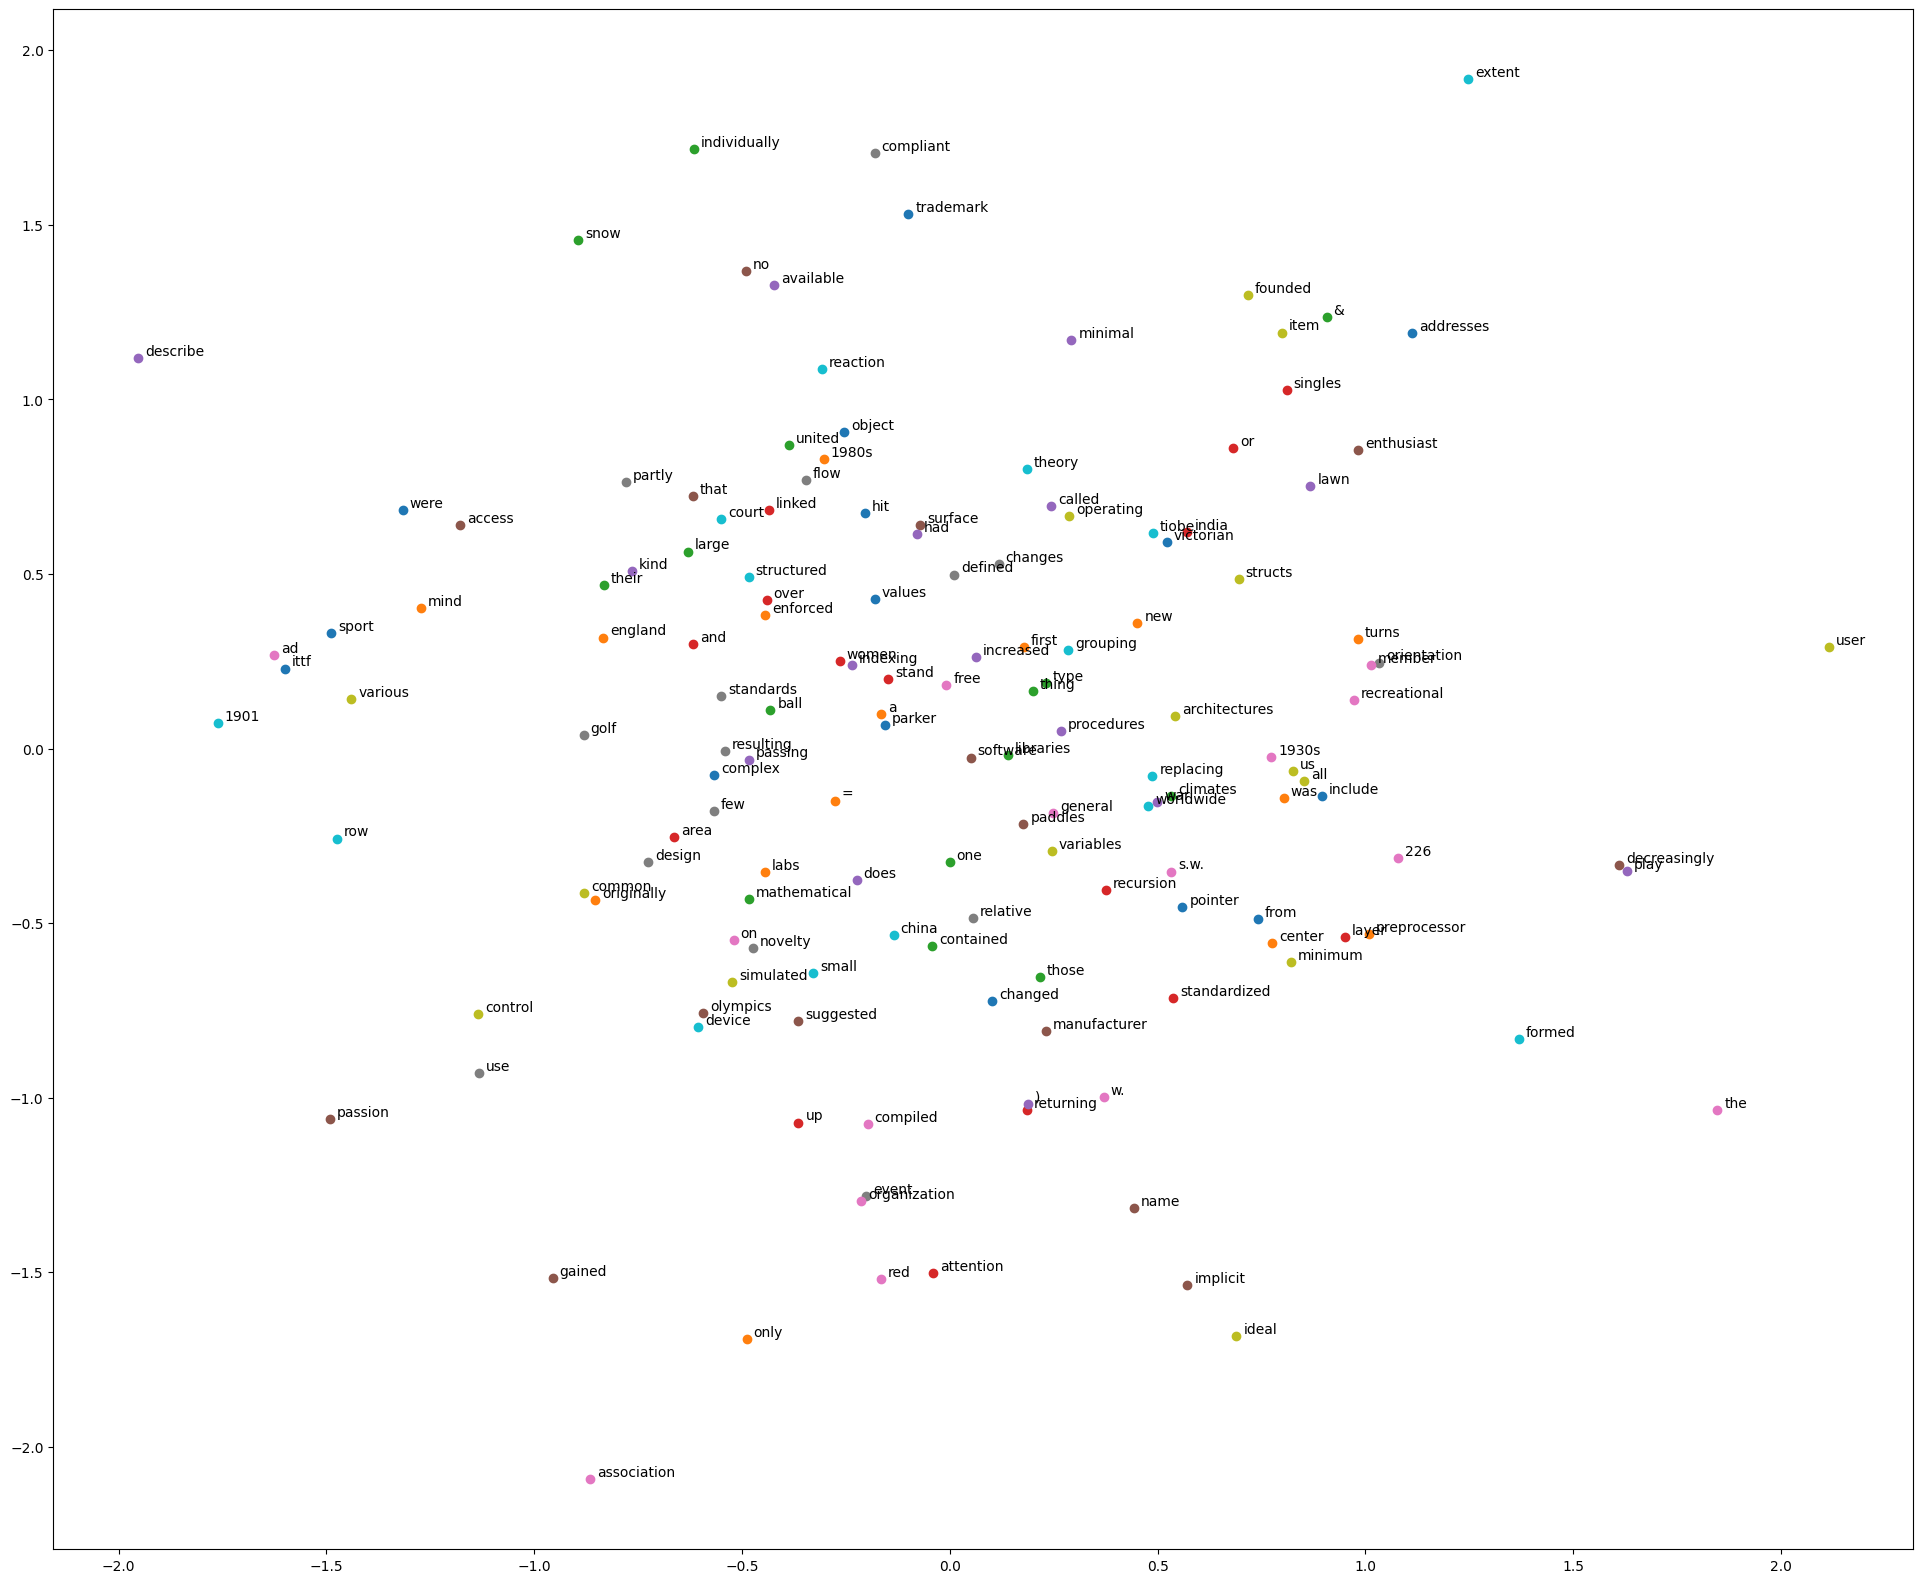

In [62]:
plt.figure(figsize=(24,20))
for i, word in enumerate(vocabs[:150]): #loop each unique vocab
    x, y = get_embed(model1, word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

In [63]:
sampleWords = ['c', 'table tennis', 'features', 'code', 'racquet', 'sport', 'language', 'net']

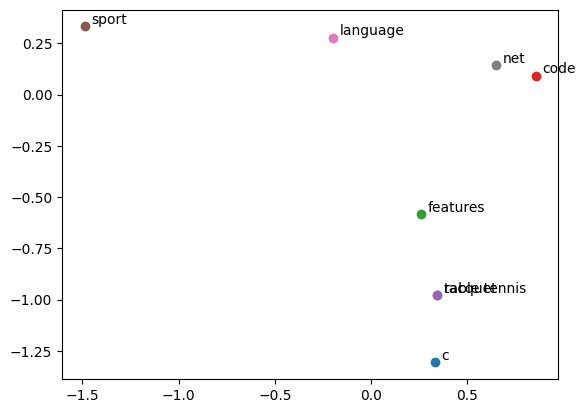

In [64]:
for word in sampleWords:
    x, y = get_embed(model1, word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')

### 7.2) Skipgram with negative sampling

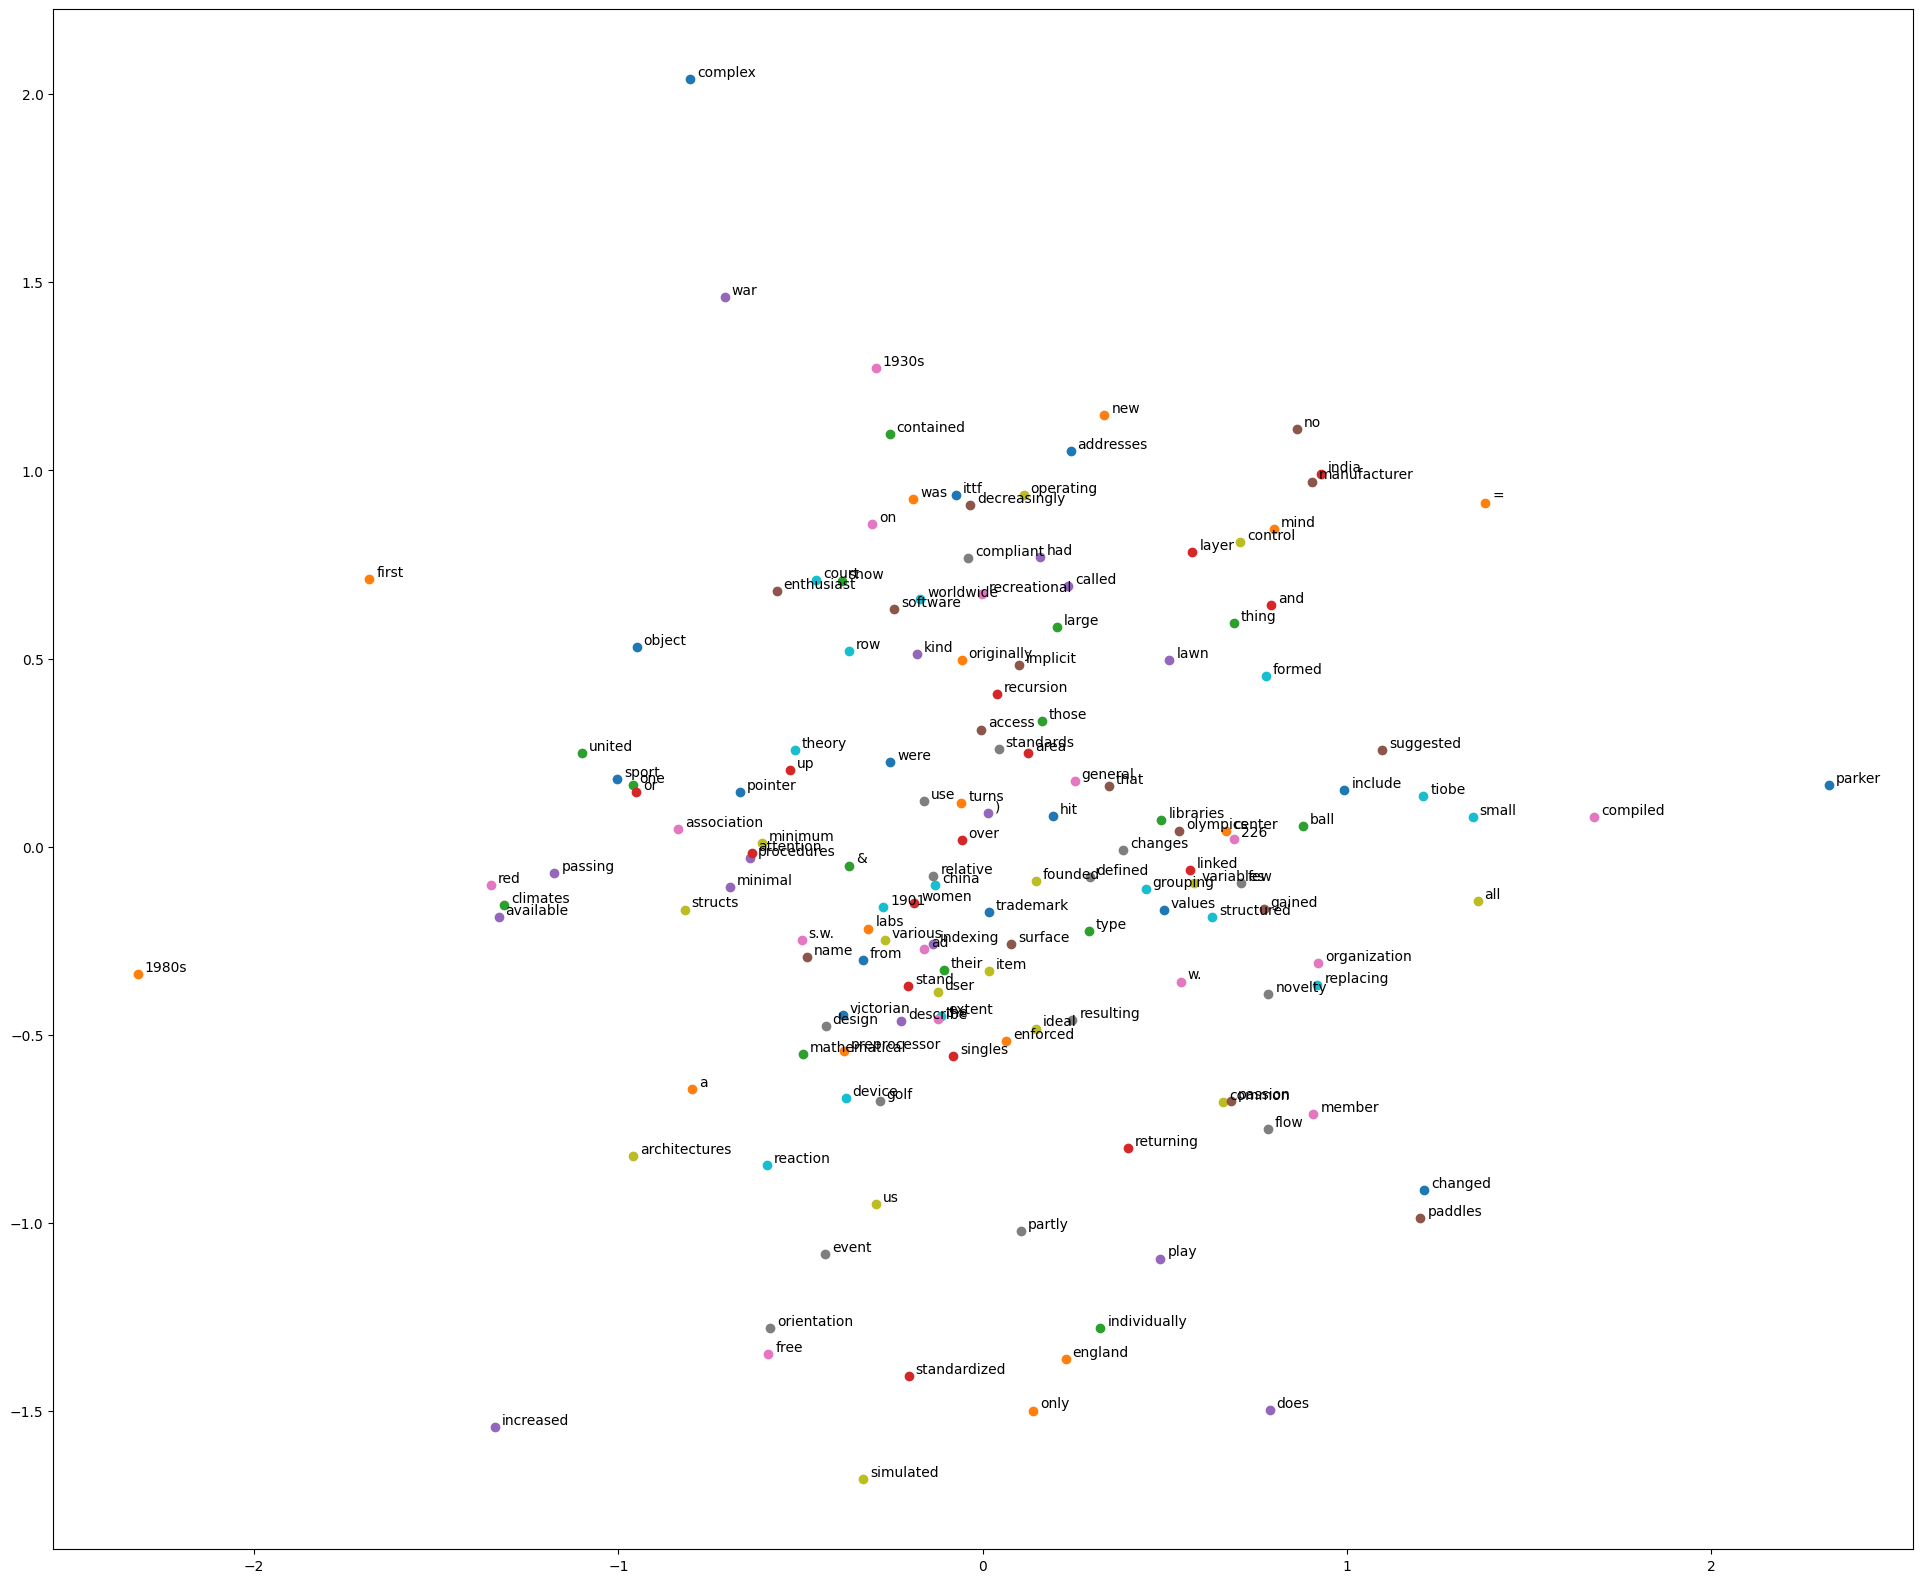

In [65]:
plt.figure(figsize=(24,20))
for i, word in enumerate(vocabs[:150]): #loop each unique vocab
    x, y = get_embed(model2, word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

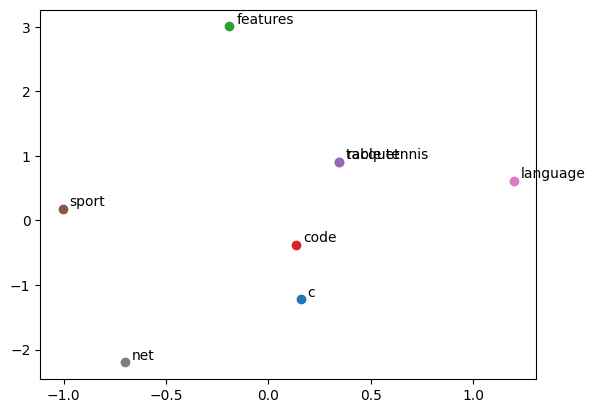

In [66]:
for word in sampleWords:
    x, y = get_embed(model2, word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')

## 8) Observation

Both skipgram and its negative sampling version took almost same amount of time to train the embeddings. However, it is assumed that the negative sampling should train faster due to being more optimized. In this case, because the training sample was not very big, the difference is not great. So, it could also be unreliable because on some runs, skipgram is shown to train faster.

Because the vobaculary for is quite big, very selected words specific to the topics, badminton and python programming language, were used for smaller version of embedding visualization. From the plots of both skip-gram and its negative sampling version, the result was not quite expected as some words are shown to be very similar than others despite being less similar. Maybe due to the limitation of the corpus, the models couldn't learn the embeddings properly based on word similarity.

# CBOW Implementation

## 1) Preparing data for training

In [67]:
skipgrams = []

for sent in corpus_tokenized:
    for i in range(window_size, len(sent) - window_size):
        center_word = word2index[sent[i]]
        outside_words = []
        for j in range(1, window_size + 1):
            outside_words.append(word2index[sent[i-j]])
            outside_words.append(word2index[sent[i+j]])
            
        for o in outside_words:
            skipgrams.append([center_word, o])

skipgrams[:15]

[[341, 278],
 [341, 339],
 [341, 351],
 [341, 527],
 [339, 341],
 [339, 527],
 [339, 278],
 [339, 203],
 [527, 339],
 [527, 203],
 [527, 341],
 [527, 395],
 [203, 527],
 [203, 395],
 [203, 339]]

In [68]:
window_size = 2

In [69]:
skipgrams_CBOW = []

for sent in corpus_tokenized:
    for i in range(window_size, len(sent) - window_size):
        center_word   = sent[i]
        outside_words = []
        
        low  = i - window_size
        high = i + window_size
        for j in range(low, high + 1):
            if j == i:
                continue
            outside_words.append(sent[j])
        skipgrams_CBOW.append([center_word, outside_words])

In [70]:
skipgrams_CBOW[:15]

[[',', ['table', 'tennis', 'also', 'known']],
 ['also', ['tennis', ',', 'known', 'as']],
 ['known', [',', 'also', 'as', 'ping']],
 ['as', ['also', 'known', 'ping', '-']],
 ['ping', ['known', 'as', '-', 'pong']],
 ['-', ['as', 'ping', 'pong', 'and']],
 ['pong', ['ping', '-', 'and', 'whiff']],
 ['and', ['-', 'pong', 'whiff', '-']],
 ['whiff', ['pong', 'and', '-', 'whaff']],
 ['-', ['and', 'whiff', 'whaff', ',']],
 ['whaff', ['whiff', '-', ',', 'is']],
 [',', ['-', 'whaff', 'is', 'a']],
 ['is', ['whaff', ',', 'a', 'racket']],
 ['a', [',', 'is', 'racket', 'sport']],
 ['racket', ['is', 'a', 'sport', 'derived']]]

In [71]:
cbow = []

for sent in corpus_tokenized:
    for i in range(window_size, len(sent) - window_size):
        center_word   = word2index[sent[i]]
        outside_words = []
        
        low  = i - window_size
        high = i + window_size
        for j in range(low, high + 1):
            if j == i:
                continue
            outside_words.append(word2index[sent[j]])
        cbow.append([center_word, outside_words])

In [72]:
cbow[:15]

[[341, [351, 278, 339, 527]],
 [339, [278, 341, 527, 203]],
 [527, [341, 339, 203, 395]],
 [203, [339, 527, 395, 510]],
 [395, [527, 203, 510, 229]],
 [510, [203, 395, 229, 93]],
 [229, [395, 510, 93, 180]],
 [93, [510, 229, 180, 510]],
 [180, [229, 93, 510, 200]],
 [510, [93, 180, 200, 341]],
 [200, [180, 510, 341, 643]],
 [341, [510, 200, 643, 21]],
 [643, [200, 341, 21, 210]],
 [21, [341, 643, 210, 90]],
 [210, [643, 21, 90, 600]]]

In [73]:
cbow[0][1]

[351, 278, 339, 527]

In [74]:
def random_batch_cbow(batch_size, corpus, cbow):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(cbow)), batch_size, replace=False) #randomly pick without replacement
        
    for i in random_index:
        random_inputs.append([cbow[i][0]])  # target, e.g., 2
        random_labels.append([cbow[i][1]])  # context word, e.g., 3
            
    return np.array(random_inputs), np.array(random_labels).squeeze()

In [75]:
random_batch_cbow(2, corpus, cbow)[1]

array([[487, 214, 278, 214],
       [ 93, 233, 481, 511]])

## 2) Model

In [76]:
class CBOW(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(CBOW, self).__init__()
        self.emb_size = emb_size
        self.input_word  = nn.Embedding(voc_size, emb_size)
        self.output_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        batch_size = center_word.shape[0]
        
        #convert them into embedding
        center_word_embed  = self.output_word(center_word)   #(batch_size, 1, emb_size)
        outside_word_embed = self.input_word(outside_word)   #(batch_size, window_size * 2, emb_size)
        all_vocabs_embed   = self.output_word(all_vocabs)    #(batch_size, voc_size, emb_size)        
        
        # mean of input word embeddings
        v_mean = torch.sum(outside_word_embed, 1) / len(outside_word) #(batch_size, emb_size)
        
        ucv = center_word_embed.bmm(v_mean.reshape(batch_size, 1, self.emb_size).transpose(1, 2)).squeeze()
        #(batch_size, 1, emb_size) @ (batch_size, emb_size, 1) = (batch_size, 1, 1) ==> (batch_size, 1)
        
        ujv = all_vocabs_embed.bmm(v_mean.reshape(batch_size, 1, self.emb_size).transpose(1, 2)).squeeze(2)
        #(batch_size, voc_size, emb_size) @ (batch_size, emb_size, 1) = (batch_size, voc_size)
        
        ujv_log_exp = torch.log(torch.exp(ujv))
        # (batch_size, voc_size) -> (batch_size,)
        
        loss_fn = - ucv + torch.sum(ujv_log_exp, 1)
        # - (batch_size, 1) + (batch_size, 1) = (batch_size, 1)
        
        return torch.mean(loss_fn) # scaler for back-propagation

<b>Test Model</b>

In [77]:
model = CBOW(voc_size, emb_size=2)

In [78]:
input, label = random_batch_cbow(2, corpus, cbow)
input_tensor = torch.LongTensor(input)  
label_tensor = torch.LongTensor(label)
input_tensor.shape, label_tensor.shape

(torch.Size([2, 1]), torch.Size([2, 4]))

In [79]:
input_tensor[0], label_tensor[0]

(tensor([450]), tensor([643, 165, 233, 584]))

In [80]:
model(input_tensor, label_tensor, all_vocabs)

tensor(-0.7168, grad_fn=<MeanBackward0>)

## 3) Training

In [81]:
emb_size = 2
model3 = SkipgramNeg(voc_size, emb_size)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [82]:
train_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()
    #get random batch
    input_batch, label_batch = random_batch_cbow(batch_size, corpus_tokenized, cbow)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    #loss = model
    loss = model3(input_batch, label_batch, all_vocabs)
    
    #backpropagate
    loss.backward()
    
    #update alpha
    optimizer.step()
    
    total_time = time.time() - start_time
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {total_time}")
        
total_training_time = time.time() - train_start_time
print("Total trainig time:", total_training_time)

Total trainig time: 0.1192770004272461


## 4) Visualizing Embedding

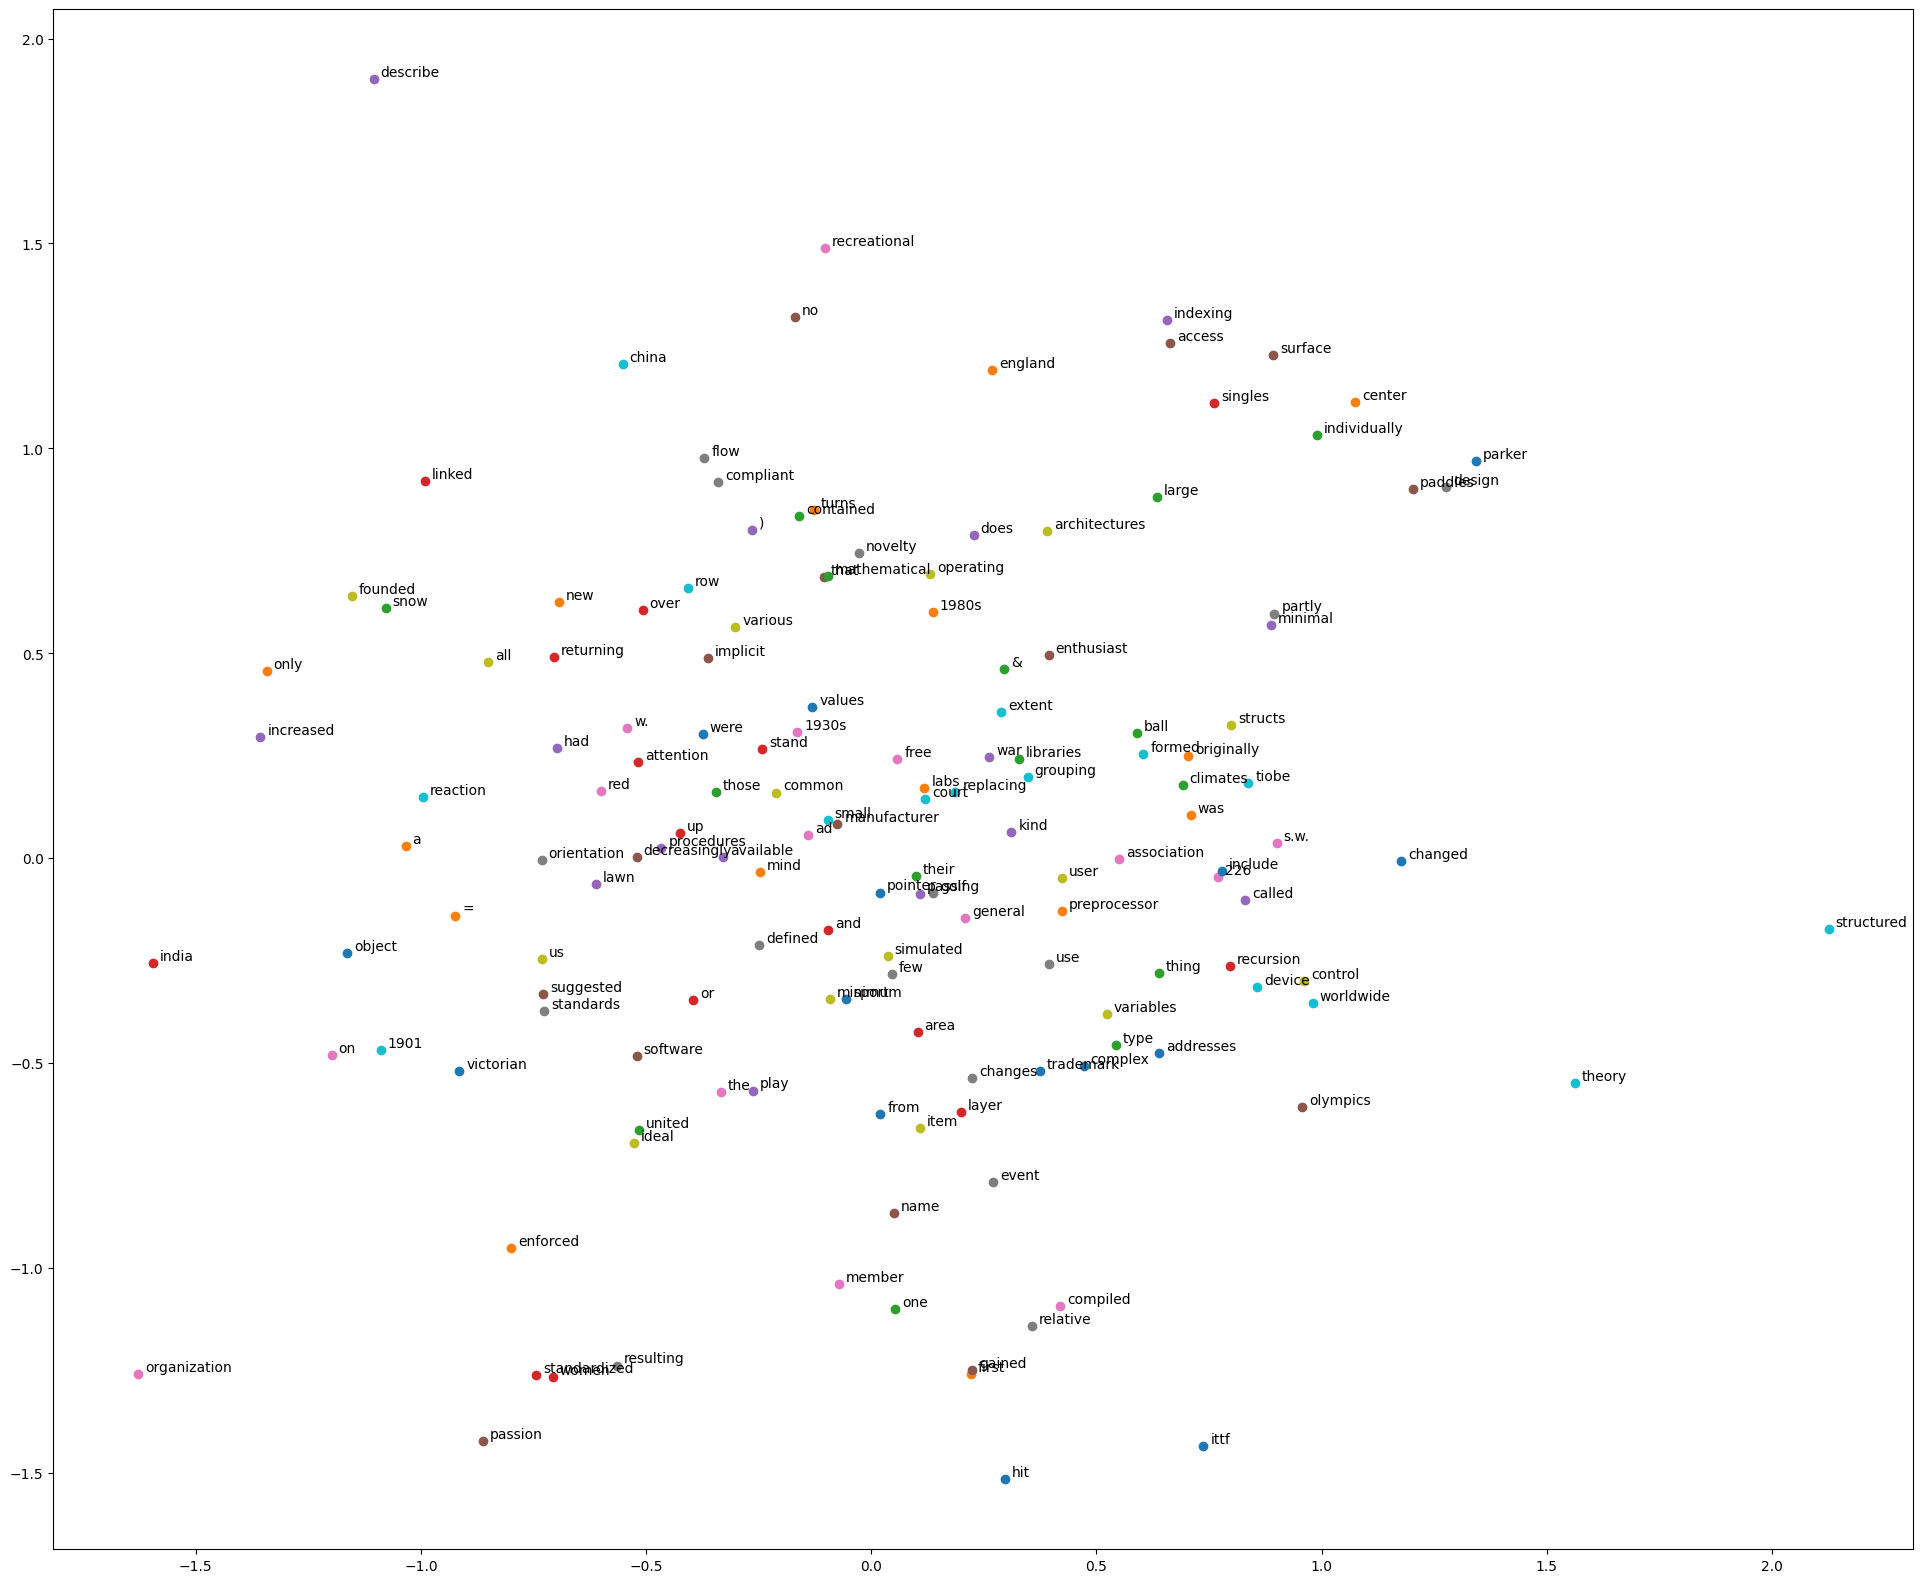

In [83]:
plt.figure(figsize=(24,20))
for i, word in enumerate(vocabs[:150]): #loop each unique vocab
    x, y = get_embed(model3, word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

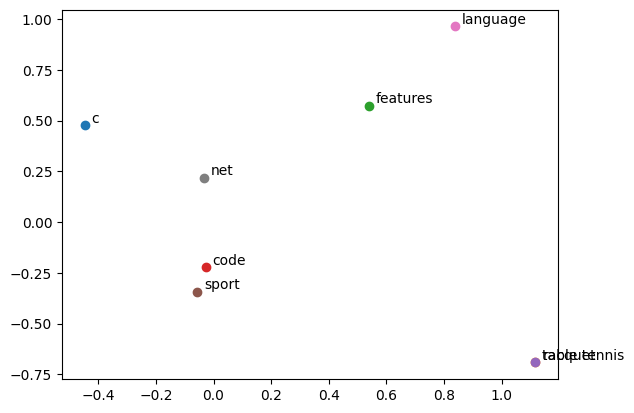

In [84]:
for word in sampleWords:
    x, y = get_embed(model3, word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')